# GHZ state in Rydberg atoms

In this tutorial, we describe the preparation of the $N$-particle GHZ state

$$|\text{GHZ}_N\rangle = \frac{1}{\sqrt{2}}\left(|0101\dots\rangle + |1010\dots\rangle\right),$$
in a linear chain of Rydberg atoms, as described in [Omran et al. 2019](https://www.science.org/doi/10.1126/science.aax9743).


1D array of Rydberg atoms driven by global pulses can be desribed with the following Hamiltonian
$$H(t) =  \frac{\Omega(t)}{2}\sum_{i = 1}^N\sigma_x^{(i)} - \sum_{i = 1}^N\Delta_i(t)n_i + \sum_{i < j}\frac{V}{|i-j|^6}n_in_j,$$
where $n_i = (1 - \sigma^z_i)/2$ are the excited state occupation operators. $\Delta_i(t) = \Delta(t) + \delta_i$ is the local effective detuning set by the Rydberg laser and the local light shift. We set $\delta_i = \delta_e$ to be non-zero only on atoms 1 and $N$.

In [1]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using ProgressMeter
using Random

ProgressMeter.ijulia_behavior(:clear);

In [69]:
T = 0.5 # in μs
V = 2π * 24.0 # in MHz
δe = -2π * 4.5 # in MHz
n_atoms = 4

bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) - sigmaz(bs))

bsys = tensor([bs for i in 1:n_atoms]...)
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]])
H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

We provide initial guesses for our pulses.

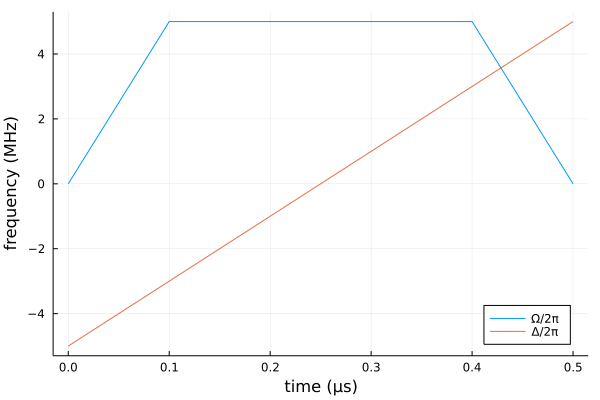

In [97]:
Ω₀(t) = 2π * min(5.0, 25.0 * t / T, 25.0 * (T - t) / T)
Δ₀(t) = 2π * (10.0 * t / T - 5.0)

ts = collect(0.0:0.001:T)
plot(ts, Ω₀.(ts)/2π, label="Ω/2π")
plot!(ts, Δ₀.(ts)/2π, label="Δ/2π")
plot!(xlabel="time (μs)", ylabel="frequency (MHz)", legend=:bottomright)

We use a dense neural network with two output notes to represent our pulses $\Omega(t)$ and $\Delta(t)$.

In [92]:
n_neurons = 8
Random.seed!(0)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 2))

n_params = length(initial_params(ann))
println("Number of parameters: ", n_params)

Ω(p, t) = ann([t], p)[1] + Ω₀(t)
Δ(p, t) = ann([t], p)[2] + Δ₀(t);

Number of parameters: 106


Finally, we define our problem and solve it.

In [93]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)

cost = CostFunction((x, y) -> 1.0 - abs2(x'*y), p -> Ω(p, 0.0)^2 + Ω(p, T)^2)
trans = StateTransform(ground_state(n_atoms) => GHZ_state(n_atoms))
H = Hamiltonian(H0, [H1, H2], (p, t) -> [Ω(p, t), Δ(p, t)]);

In [94]:
tout, psit = schroedinger_dynamic(ts, ground_state(n_atoms), H, zeros(n_params));

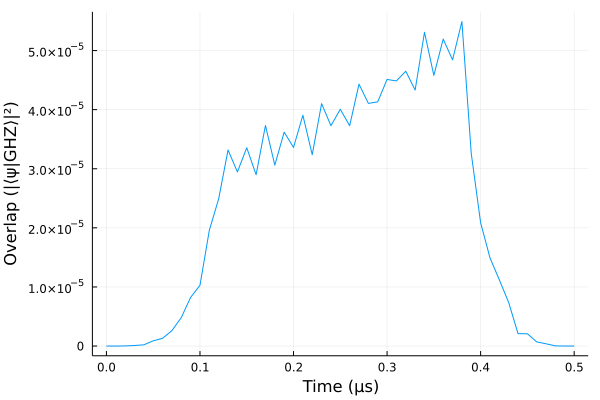

In [95]:
plot(ts, real(expect(dm(GHZ_state(n_atoms)), psit)))
plot!(xlabel="Time (μs)", ylabel="Overlap (|⟨ψ|GHZ⟩|²)", legend=false)

In [76]:
prob = QOCProblem(H, trans, (0.0, T), cost)
sol = solve(prob, zeros(n_params), ADAM(0.1); maxiter=100);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
  distance:     0.999999982733417
  constraints:  1.0093846605537275e-10


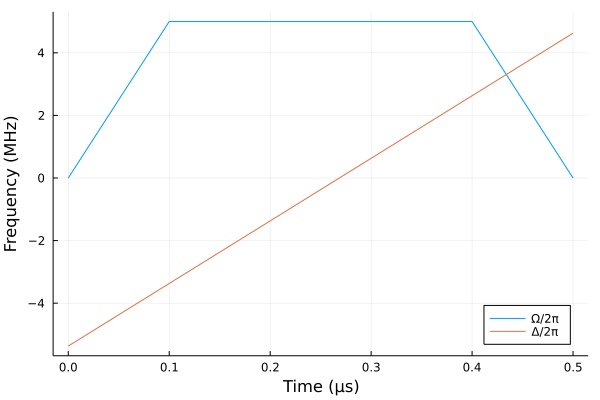

In [98]:
plot(ts, [Ω(sol.params, t)/2π for t in ts], label="Ω/2π")
plot!(ts, [Δ(sol.params, t)/2π for t in ts], label="Δ/2π")
plot!(xlabel="Time (μs)", ylabel="Frequency (MHz)", legend=:bottomright)

In [78]:
tout, psit = schroedinger_dynamic(ts, ground_state(n_atoms), H, sol.params);

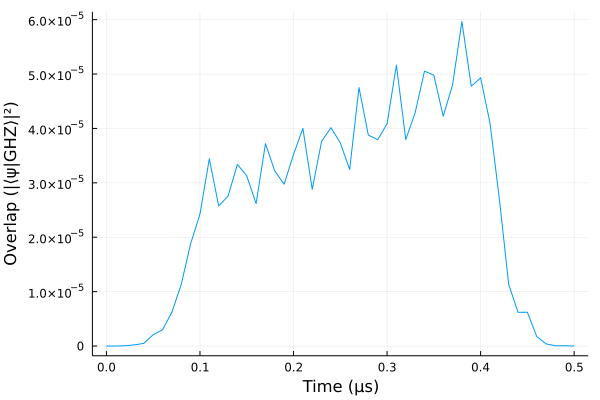

In [79]:
plot(ts, real(expect(dm(GHZ_state(n_atoms)), psit)))
plot!(xlabel="Time (μs)", ylabel="Overlap (|⟨ψ|GHZ⟩|²)", legend=false)